In [ ]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import zipfile
import random
import math
import string

import open_clip
from PIL import Image
from datasets import load_dataset
from transformers import AutoTokenizer, BartForConditionalGeneration
from huggingface_hub import hf_hub_download

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW

from tqdm.auto import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
DRIVE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/WOA7015_Advanced_ML/AA"
WEIGHT_FOLDER = DRIVE_FOLDER + "/Weights"

if not os.path.exists(WEIGHT_FOLDER):
    os.makedirs(WEIGHT_FOLDER)

BASE_NAME = "med_vqa_model_1.pth"

Mounted at /content/drive


# Dataset

In [ ]:
REPO_ID = "BoKelvin/SLAKE"
EXTRACT_PATH = "./slake_extract"

print("Downloading images from Hugging Face...")
try:
    img_zip_path = hf_hub_download(repo_id=REPO_ID, filename="imgs.zip", repo_type="dataset")
except Exception as e:
    print(f"Download failed: {e}")

if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    print("Extracting images...")
    with zipfile.ZipFile(img_zip_path, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print("Images already extracted.")

if os.path.exists(os.path.join(EXTRACT_PATH, 'imgs')):
    IMG_DIR = os.path.join(EXTRACT_PATH, 'imgs')
    print(f"Found subfolder 'imgs'. Setting IMG_DIR to: {IMG_DIR}")
else:
    IMG_DIR = EXTRACT_PATH
    print(f"No subfolder found. Setting IMG_DIR to: {IMG_DIR}")

test_path = os.path.join(IMG_DIR, 'xmlab0', 'source.jpg')
if os.path.exists(test_path):
    print("SUCCESS: Verified image path structure.")
else:
    print(f"WARNING: Could not find test image at {test_path}.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


imgs.zip:   0%|          | 0.00/212M [00:00<?, ?B/s]

Extracting images...
Extraction complete.
Found subfolder 'imgs'. Setting IMG_DIR to: ./slake_extract/imgs
SUCCESS: Verified image path structure.


In [ ]:
BIOMEDCLIP_ID = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
BIOBART_ID = 'GanjinZero/biobart-base'

print("Loading BioMedCLIP transforms...")
_, _, preprocess_img = open_clip.create_model_and_transforms(BIOMEDCLIP_ID)

print("Loading BioBART tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(BIOBART_ID)

Loading BioMedCLIP transforms...


open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Loading BioBART tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128

def transform_fn(batch):
    images = []
    keep_indices = []

    for i, img_name in enumerate(batch['img_name']):
        full_path = os.path.join(IMG_DIR, img_name)
        try:
            image = Image.open(full_path).convert("RGB")
            images.append(preprocess_img(image))
            keep_indices.append(i)
        except (FileNotFoundError, OSError):
            print(f"WARNING: Skipping missing image {img_name}")
            continue

    # Make sure these lists contain data for loaded images only
    valid_questions = [batch['question'][i] for i in keep_indices]
    valid_answers = [str(batch['answer'][i]) for i in keep_indices]
    valid_types = [batch['answer_type'][i] for i in keep_indices]

    text_inputs = tokenizer(
        valid_questions,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    target_inputs = tokenizer(
        valid_answers,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    labels = target_inputs["input_ids"]
    # Ignore padding tokens (prevent prediction of text padding)
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "pixel_values": images,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "labels": labels,
        "answer_text": valid_answers,
        "answer_type": valid_types
    }

In [ ]:
def custom_collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    # Batch can't contain strings, convert to list
    answer_texts = [item['answer_text'] for item in batch]
    answer_types = [item['answer_type'] for item in batch]

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'answer_text': answer_texts,
        'answer_type': answer_types
    }

In [ ]:
print("Loading BoKelvin/SLAKE dataset...")
dataset = load_dataset(REPO_ID)
dataset = dataset.filter(lambda example: example['q_lang'] == 'en')
dataset = dataset.with_transform(transform_fn)

train_loader = DataLoader(dataset['train'], batch_size=16, shuffle=True, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)
train_subset = Subset(dataset['train'], range(0, 200))
train_subset_loader = DataLoader(train_subset, batch_size=32, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset['validation'], batch_size=32, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset['test'], batch_size=32, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)

print("Data Setup Complete.")

Loading BoKelvin/SLAKE dataset...


README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9835 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2094 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9835 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2099 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2094 [00:00<?, ? examples/s]

Data Setup Complete.


# Model (BioMedCLIP + BioBART)

In [ ]:
class MedVQAModel(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device

        # Vision Encoder (BioMedCLIP)
        clip_model, _, _ = open_clip.create_model_and_transforms(BIOMEDCLIP_ID)
        self.visual_encoder = clip_model.visual
        self.visual_encoder.requires_grad_(False)

        # Text Decoder (BioBART)
        self.decoder = BartForConditionalGeneration.from_pretrained(BIOBART_ID)
        self.decoder_dim = self.decoder.config.d_model # 768

        # Projector
        self.projector = nn.Sequential(
            nn.Linear(512, 2048),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(2048, self.decoder_dim)
        )

    # Helper to safely get scaled embeddings
    def get_text_embeddings(self, input_ids):
        # Access the shared embedding layer
        embed_tokens = self.decoder.model.shared(input_ids)

        # Scale embeddings if required by the config
        if getattr(self.decoder.config, "scale_embedding", False):
            embed_scale = math.sqrt(self.decoder.config.d_model)
            embed_tokens = embed_tokens * embed_scale

        return embed_tokens

    def prepare_multimodal_inputs(self, pixel_values, input_ids, attention_mask):
        # Encode image
        with torch.no_grad():
            image_embeds = self.visual_encoder(pixel_values) # (Batch, 512)

        # Project image
        image_embeds = self.projector(image_embeds).unsqueeze(1) # (Batch, 1, 768)

        # Encode text
        inputs_embeds = self.get_text_embeddings(input_ids)

        # Concatenate (image + text)
        combined_embeds = torch.cat([image_embeds, inputs_embeds], dim=1)

        # Extend mask (cater for concat)
        ones = torch.ones((input_ids.shape[0], 1), device=input_ids.device)
        combined_mask = torch.cat([ones, attention_mask], dim=1)

        return combined_embeds, combined_mask

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):
        # Prepare inputs
        combined_embeds, combined_mask = self.prepare_multimodal_inputs(pixel_values, input_ids, attention_mask)

        # Decode
        outputs = self.decoder(
            inputs_embeds=combined_embeds,
            attention_mask=combined_mask,
            labels=labels
        )

        return outputs

    def generate(self, pixel_values, input_ids, attention_mask, max_new_tokens=20):
        with torch.no_grad():
            # Prepare inputs
            combined_embeds, combined_mask = self.prepare_multimodal_inputs(pixel_values, input_ids, attention_mask)

            # Generate
            return self.decoder.generate(
                inputs_embeds=combined_embeds,
                attention_mask=combined_mask,
                max_new_tokens=max_new_tokens,
                num_beams=3
            )

# Train and Evaluate

In [ ]:
# Lowercase, remove punctuation, clean whitespace
def normalize_text(text):
    text = text.lower()
    text = "".join([c for c in text if c not in string.punctuation])
    return " ".join(text.split())

def evaluate(model, loader, tokenizer, device, desc="Evaluating"):
    model.eval()

    correct_open = 0; total_open = 0
    correct_closed = 0; total_closed = 0
    total_loss = 0
    bleu_open = []; bleu_closed = []

    progress_bar = tqdm(loader, desc=desc, leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values, input_ids, mask, labels=labels)
            total_loss += outputs.loss.item()

            generated_ids = model.generate(pixel_values, input_ids, mask, max_new_tokens=20)
            pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            ref_texts = batch['answer_text']
            types = batch['answer_type']

            for pred, ref, ans_type in zip(pred_texts, ref_texts, types):
                pred_clean = normalize_text(pred)
                ref_clean = normalize_text(ref)

                # Accuracy (checks for entire string match)
                is_correct = (pred_clean == ref_clean)

                # BLEU (1-gram)
                ref_tokens = ref_clean.split()
                pred_tokens = pred_clean.split()
                if not pred_tokens: pred_tokens = [""]
                score = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)

                if ans_type == 'CLOSED':
                    total_closed += 1
                    bleu_closed.append(score)
                    if is_correct: correct_closed += 1
                else:
                    total_open += 1
                    bleu_open.append(score)
                    if is_correct: correct_open += 1

    avg_loss = total_loss / len(loader)

    acc_open = correct_open / total_open if total_open > 0 else 0
    acc_closed = correct_closed / total_closed if total_closed > 0 else 0

    total_samples = total_open + total_closed
    acc_overall = (correct_open + correct_closed) / total_samples if total_samples > 0 else 0

    avg_bleu_open = sum(bleu_open) / len(bleu_open) if bleu_open else 0
    avg_bleu_closed = sum(bleu_closed) / len(bleu_closed) if bleu_closed else 0
    all_bleu = bleu_open + bleu_closed
    avg_bleu_overall = sum(all_bleu) / len(all_bleu) if all_bleu else 0

    return {
        "loss": avg_loss,
        "acc_open": acc_open,
        "acc_closed": acc_closed,
        "acc_overall": acc_overall,
        "bleu_open": avg_bleu_open,
        "bleu_closed": avg_bleu_closed,
        "bleu_overall": avg_bleu_overall
    }

In [ ]:
def train_and_validate(model, train_loader, val_loader, train_subset_loader, optimizer, tokenizer, device, num_epochs):
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [],  "val_acc": []
    }

    best_val_loss = float('inf')
    best_val_overall_acc = 0.0
    best_val_open_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values, input_ids, mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        val_res = evaluate(model, val_loader, tokenizer, device, desc="Validating")

        # Evaluate on subset of train set (whole train set would be slow)
        train_res = evaluate(model, train_subset_loader, tokenizer, device, desc="Checking Train Acc")

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_res['loss'])
        history["train_acc"].append(train_res['acc_overall'])
        history["val_acc"].append(val_res['acc_overall'])

        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {val_res['loss']:.4f}")
        print(f"  Train Acc:  {train_res['acc_overall']:.4f} | Val Acc:  {val_res['acc_overall']:.4f}")
        print(f"  Val BLEU-1: {val_res['bleu_overall']:.4f}")

        if val_res['loss'] < best_val_loss:
            best_val_loss = val_res['loss']
            save_name = f"loss_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Val Loss: {best_val_loss:.4f})")

        if val_res['acc_overall'] > best_val_overall_acc:
            best_val_overall_acc = val_res['acc_overall']
            save_name = f"acc_overall_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Overall Acc: {best_val_overall_acc:.4f})")

        if val_res['acc_open'] > best_val_open_acc:
            best_val_open_acc = val_res['acc_open']
            save_name = f"acc_open_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Open Acc: {best_val_open_acc:.4f})")

    print("\nTraining Complete.")
    return history

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MedVQAModel(device).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

history = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_subset_loader=train_subset_loader,
    optimizer=optimizer,
    tokenizer=tokenizer,
    device=device,
    num_epochs=15,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

Starting training for 15 epochs...


Epoch 1/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.9571 | Val Loss: 0.4102
  Train Acc:  0.5700 | Val Acc:  0.5632
  Val BLEU-1: 0.6017
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.4102)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.5632)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.5483)


Epoch 2/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.3784 | Val Loss: 0.2800
  Train Acc:  0.6600 | Val Acc:  0.6629
  Val BLEU-1: 0.6891
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2800)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.6629)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6403)


Epoch 3/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2728 | Val Loss: 0.2454
  Train Acc:  0.7400 | Val Acc:  0.7018
  Val BLEU-1: 0.7324
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2454)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7018)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6624)


Epoch 4/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2274 | Val Loss: 0.2083
  Train Acc:  0.7400 | Val Acc:  0.7388
  Val BLEU-1: 0.7632
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2083)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7388)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6910)


Epoch 5/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2034 | Val Loss: 0.2032
  Train Acc:  0.6800 | Val Acc:  0.7474
  Val BLEU-1: 0.7787
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2032)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7474)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7068)


Epoch 6/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1740 | Val Loss: 0.2116
  Train Acc:  0.7750 | Val Acc:  0.7502
  Val BLEU-1: 0.7792
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7502)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7147)


Epoch 7/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1702 | Val Loss: 0.1753
  Train Acc:  0.8300 | Val Acc:  0.7759
  Val BLEU-1: 0.7998
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1753)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7759)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7195)


Epoch 8/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1523 | Val Loss: 0.1611
  Train Acc:  0.7250 | Val Acc:  0.7768
  Val BLEU-1: 0.8040
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1611)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7768)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7385)


Epoch 9/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1367 | Val Loss: 0.1873
  Train Acc:  0.8700 | Val Acc:  0.7835
  Val BLEU-1: 0.8105
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7835)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7528)


Epoch 10/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1297 | Val Loss: 0.1752
  Train Acc:  0.8050 | Val Acc:  0.7768
  Val BLEU-1: 0.8083


Epoch 11/15:   0%|          | 0/308 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b089c08ef20>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b089c08ef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1600, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b089c08ef20>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, 

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1249 | Val Loss: 0.1948
  Train Acc:  0.8650 | Val Acc:  0.8034
  Val BLEU-1: 0.8321
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.8034)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7544)


Epoch 12/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1440 | Val Loss: 0.1787
  Train Acc:  0.8050 | Val Acc:  0.7930
  Val BLEU-1: 0.8205


Epoch 13/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1102 | Val Loss: 0.1809
  Train Acc:  0.8500 | Val Acc:  0.7863
  Val BLEU-1: 0.8160


Epoch 14/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1018 | Val Loss: 0.1620
  Train Acc:  0.8850 | Val Acc:  0.8082
  Val BLEU-1: 0.8335
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.8082)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7639)


Epoch 15/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.0924 | Val Loss: 0.1741
  Train Acc:  0.8450 | Val Acc:  0.7863
  Val BLEU-1: 0.8113

Training Complete.


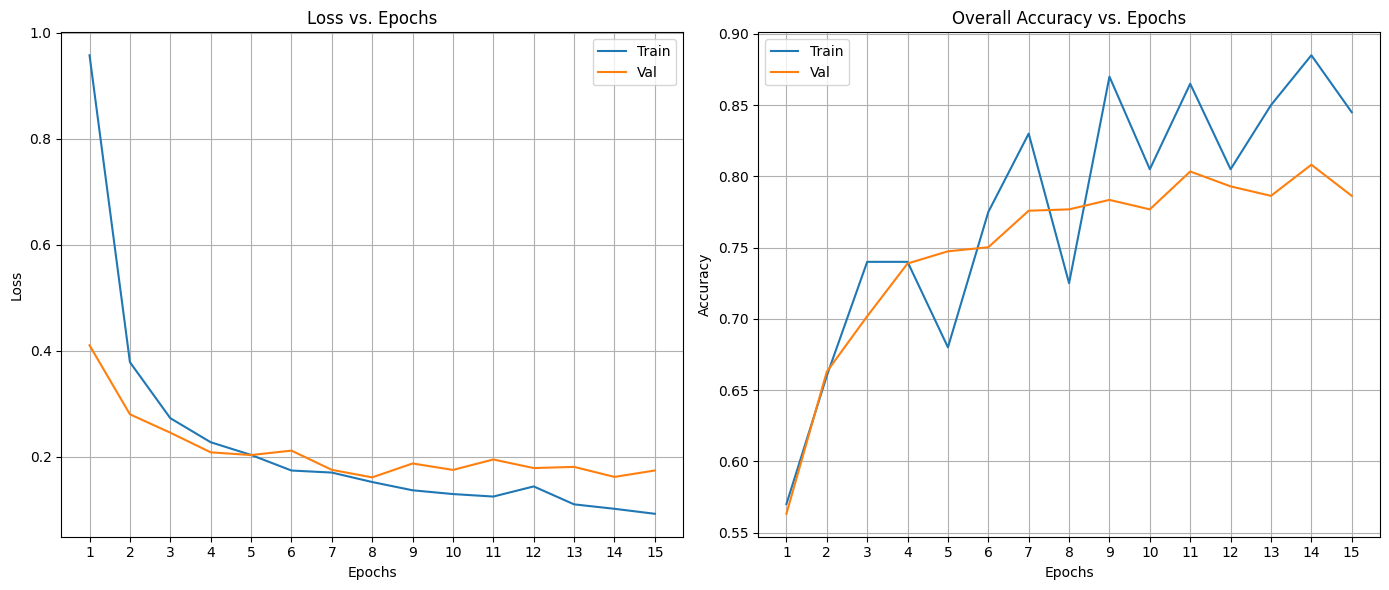

In [ ]:
def plot_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['val_acc'], label='Val')
    plt.title('Overall Accuracy vs. Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_curves(history)

# Evaluate with Test Set

In [ ]:
best_weight_path = os.path.join(WEIGHT_FOLDER, f"acc_overall_best_{BASE_NAME}")

print(f"Loading best weights from: {best_weight_path}")

if os.path.exists(best_weight_path):
    checkpoint = torch.load(best_weight_path, map_location=device)
    model.load_state_dict(checkpoint)
    print("Best weights loaded successfully.")
else:
    print(f"Warning: File not found at {best_weight_path}. Using current model weights.")

Loading best weights from: /content/drive/MyDrive/Colab Notebooks/WOA7015_Advanced_ML/AA/Weights/acc_overall_best_med_vqa_model_1.pth
Best weights loaded successfully.


In [ ]:
print("Starting evaluation on Test Set...")
results = evaluate(model, test_loader, tokenizer, device)

print("\n" + "="*40)
print("FINAL EVALUATION RESULTS")
print("="*40)
print(f"OVERALL Accuracy: {results['acc_overall']:.4f}")
print(f"OVERALL BLEU-1:   {results['bleu_overall']:.4f}")
print("-" * 40)
print(f"CLOSED Questions:")
print(f"  Accuracy:       {results['acc_closed']:.4f}")
print(f"  BLEU-1:         {results['bleu_closed']:.4f}")
print("-" * 40)
print(f"OPEN Questions:")
print(f"  Accuracy:       {results['acc_open']:.4f}")
print(f"  BLEU-1:         {results['bleu_open']:.4f}")
print("="*40)

Starting evaluation on Test Set...


Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]


FINAL EVALUATION RESULTS
OVERALL Accuracy: 0.7842
OVERALL BLEU-1:   0.8167
----------------------------------------
CLOSED Questions:
  Accuracy:       0.8678
  BLEU-1:         0.8678
----------------------------------------
OPEN Questions:
  Accuracy:       0.7302
  BLEU-1:         0.7837


# Visualize Prediction

In [ ]:
raw_test_dataset = load_dataset(REPO_ID, split="test")
raw_test_dataset = raw_test_dataset.filter(lambda x: x['q_lang'] == 'en')

def visualize_prediction(index):
    item = raw_test_dataset[index]
    img_name = item['img_name']
    question = item['question']
    answer = str(item['answer'])

    img_path = os.path.join(IMG_DIR, img_name)

    try:
        pil_image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"Could not find image: {img_path}")
        return

    pixel_values = preprocess_img(pil_image).unsqueeze(0).to(device)

    text_inputs = tokenizer(
        question,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    ).to(device)

    input_ids = text_inputs["input_ids"]
    attention_mask = text_inputs["attention_mask"]

    # Run model
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, input_ids, attention_mask)

    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    print(f"\n--- Sample {index} ---")
    print(f"Question:    {question}")
    print(f"Ground Truth: {answer}")
    print(f"Model Pred:   {prediction}")

    if prediction.strip().lower() == answer.strip().lower():
        print("Result:       ✅ MATCH")
    else:
        print("Result:       ❌ NOT MATCH")

    plt.figure(figsize=(8, 4))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(f"Type: {item['answer_type']}\nQ: {question}", fontsize=12, loc='left')
    plt.show()

In [ ]:
open_indices = [i for i, item in enumerate(raw_test_dataset) if item['answer_type'] == 'OPEN']
closed_indices = [i for i, item in enumerate(raw_test_dataset) if item['answer_type'] == 'CLOSED']

print(f"Found {len(open_indices)} OPEN questions and {len(closed_indices)} CLOSED questions.")

def show_samples_by_type(type_name, indices, num_to_show):
    print(f"\n{'='*40}")
    print(f"  VISUALIZING: {type_name} QUESTIONS")
    print(f"{'='*40}")

    # Pick random samples
    selected_indices = random.sample(indices, num_to_show)

    for idx in selected_indices:
        visualize_prediction(idx)

Found 645 OPEN questions and 416 CLOSED questions.



  VISUALIZING: CLOSED QUESTIONS

--- Sample 126 ---
Question:    Does the picture contain liver?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


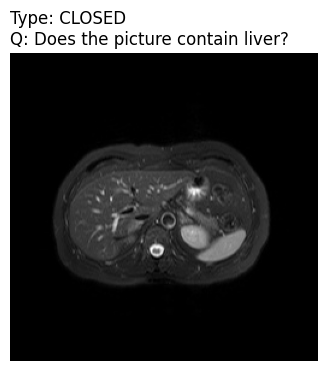


--- Sample 837 ---
Question:    Does the brain look abnormal?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


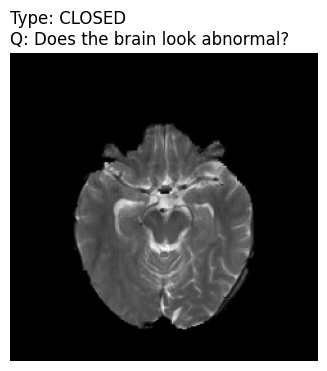


--- Sample 963 ---
Question:    Does the picture contain the organ which has the effect of sensing light?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


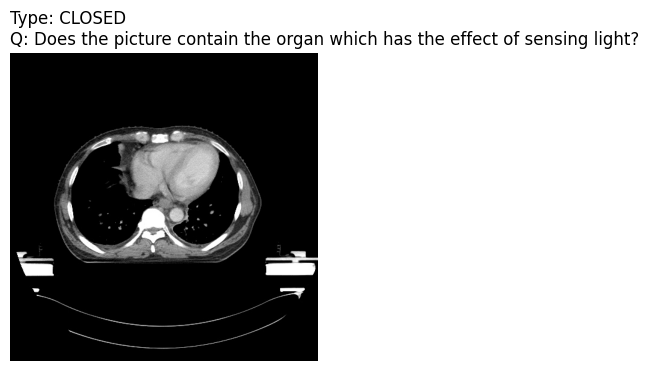


--- Sample 899 ---
Question:    Does the picture contain the organ that could be used for secreting enzymes?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


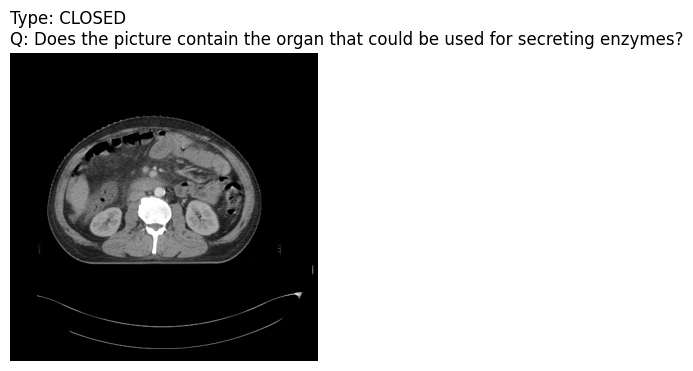


--- Sample 459 ---
Question:    Can nodule be observed on the upper right lung in this picture?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


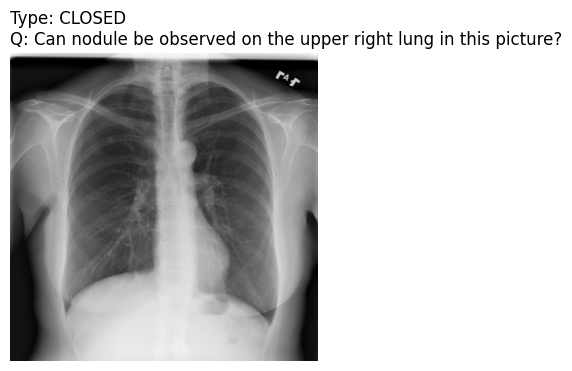


--- Sample 878 ---
Question:    Does the picture contain the organ which has the effect of detoxicating?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


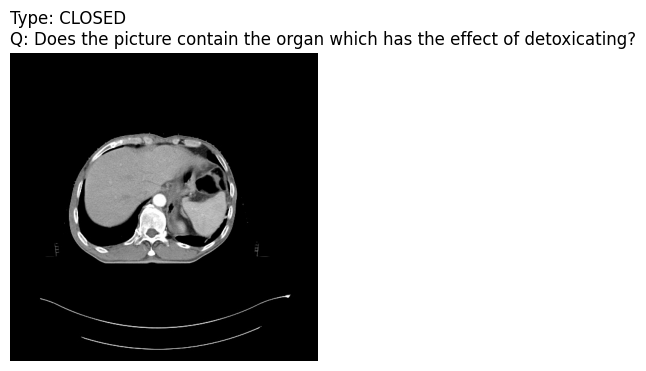


--- Sample 689 ---
Question:    Is this an MRI image with T1 weighted?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


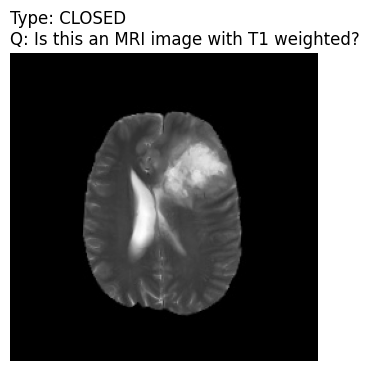


--- Sample 111 ---
Question:    Is the lung healthy?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


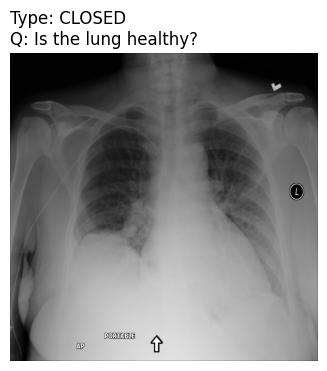


--- Sample 933 ---
Question:    Are there organs in the picture that can digest food?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


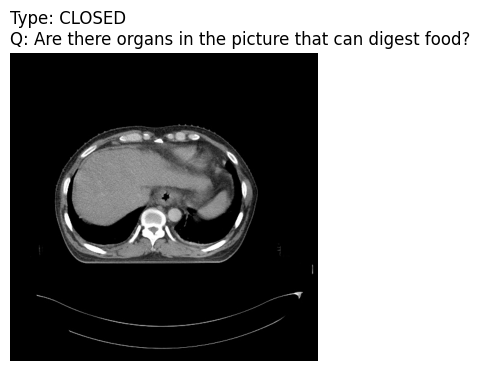


--- Sample 628 ---
Question:    Do any of the organs in the picture belong to the digestive system?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


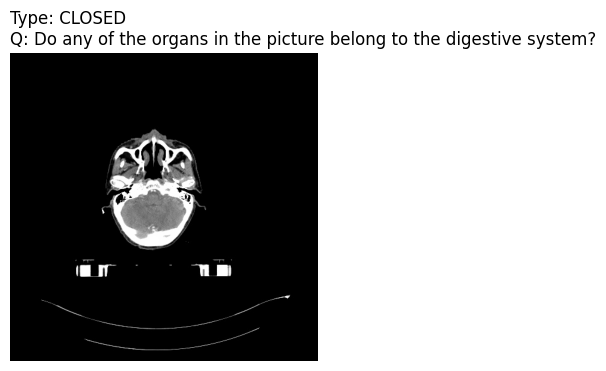

In [ ]:
show_samples_by_type("CLOSED", closed_indices, num_to_show=10)


  VISUALIZING: OPEN (Generative) QUESTIONS

--- Sample 141 ---
Question:    What modality is used to take this image?
Ground Truth: CT
Model Pred:   CT
Result:       ✅ MATCH


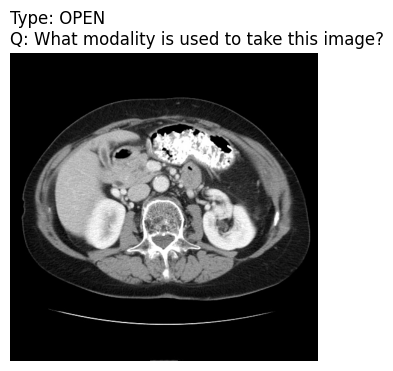


--- Sample 463 ---
Question:    What kind of symptoms will the disease on the upper right lung bring to the patient?
Ground Truth: Chest tightness, fatigue
Model Pred:   Chest tightness, fatigue
Result:       ✅ MATCH


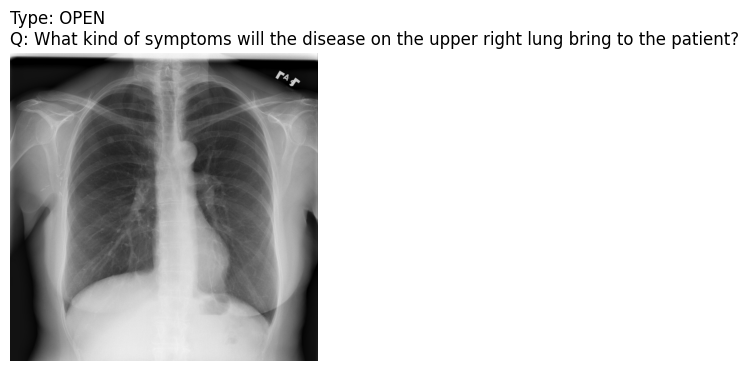


--- Sample 302 ---
Question:    Which part of the body does this image belong to?
Ground Truth: Abdomen
Model Pred:   Abdomen
Result:       ✅ MATCH


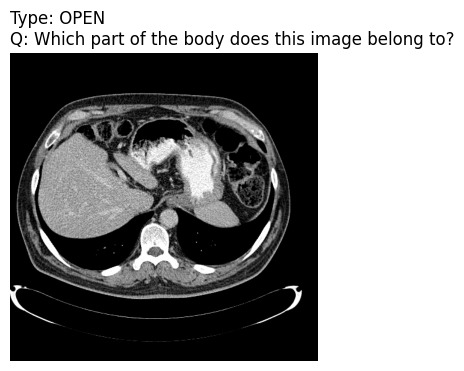


--- Sample 817 ---
Question:    Where is the brain non-enhancing tumor?
Ground Truth: Left Lobe
Model Pred:   Right Lobe
Result:       ❌ NOT MATCH


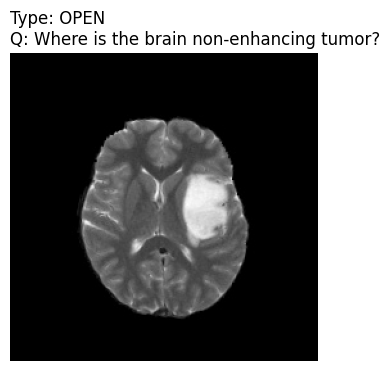


--- Sample 700 ---
Question:    Where does the picture show?
Ground Truth: Head
Model Pred:   Head
Result:       ✅ MATCH


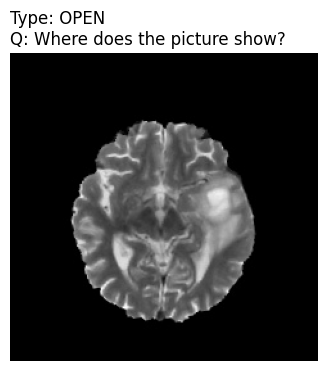


--- Sample 124 ---
Question:    How many kidneys are there in this image?
Ground Truth: 1
Model Pred:   0
Result:       ❌ NOT MATCH


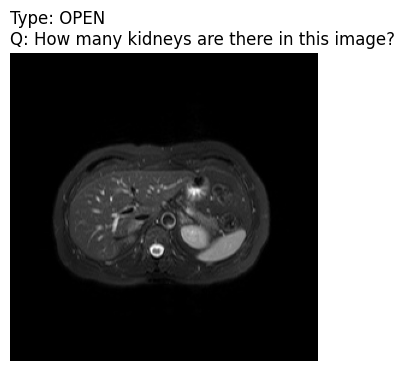


--- Sample 812 ---
Question:    How to prevent the occurrence of the disease on the lower left lobe of brain in this image?
Ground Truth: Pay attention to dietary hygiene, strengthen physical fitness and avoid brain trauma
Model Pred:   Pay attention to dietary hygiene, strengthen physical fitness and avoid brain trauma
Result:       ✅ MATCH


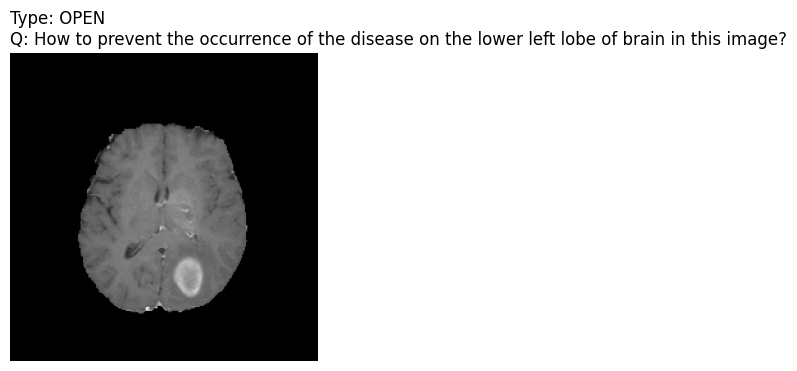


--- Sample 951 ---
Question:    Which organs/organ in the picture belong to the digestive system?
Ground Truth: Esophagus
Model Pred:   Esophagus
Result:       ✅ MATCH


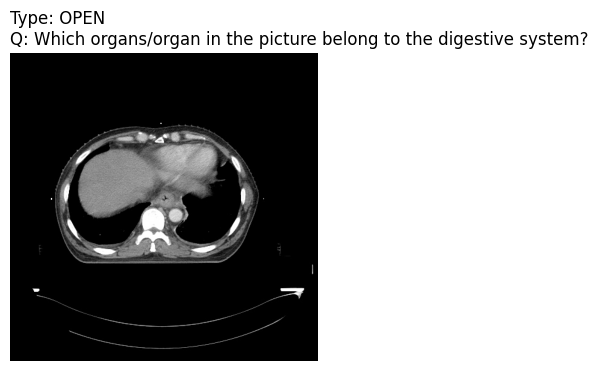


--- Sample 65 ---
Question:    Where is/are the abnormality located?
Ground Truth: Center
Model Pred:   Center
Result:       ✅ MATCH


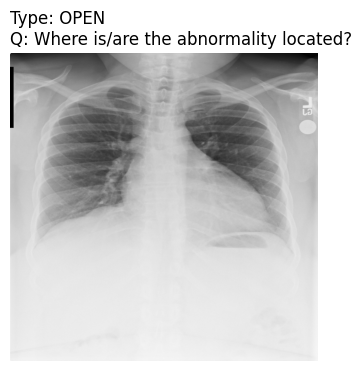


--- Sample 169 ---
Question:    What is the rightmost organ in this image?
Ground Truth: Left Lung
Model Pred:   Left Lung
Result:       ✅ MATCH


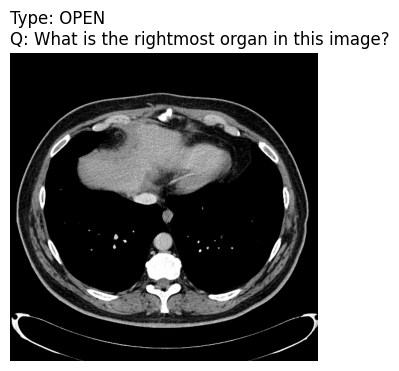

In [ ]:
show_samples_by_type("OPEN (Generative)", open_indices, num_to_show=10)